# Code for matching $\alpha$70 data to our SDSS data

DO NOT DELETE THIS FILE!

In [1]:
os.chdir('../../')

In [2]:
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import pickle
import os
import time

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

from astropy.coordinates.matching import match_coordinates_sky
from astropy.coordinates import ICRS
from astropy import units as u

import make_dictionaries
questions = make_dictionaries.questions

Load the data:

In [3]:
sample = Table.read('../fits/full_sample_debiased_w_low_z.fits')
alfalfa70_full = Table.read('../fits/ALFALFA/a70.csv')
alfalfa70_full['index'] = np.arange(len(alfalfa70_full))
sample['index'] = np.arange(len(sample))
has_OC = alfalfa70_full['OCra'] != 0
alfalfa = alfalfa70_full[has_OC] # only keep data with OC in SDSS

# Keep all of the galaxies within z < 0.05?
select_low_z = sample['REDSHIFT_1'] <= 0.05
galaxies = sample[select_low_z]

In [4]:
index_matches = np.ones((len(sample),2))*(-999)
index_matches[:,0] = np.arange(len(sample))

Scatter plot of SDSS + $\alpha$70 regions:

/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


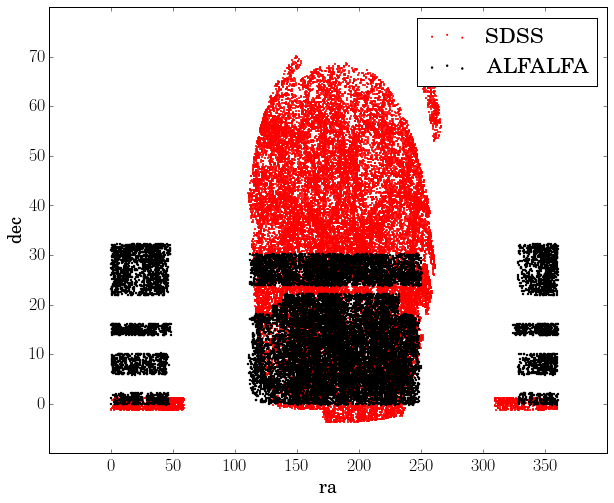

In [5]:
_ = plt.scatter(galaxies['ra_1'],galaxies['dec_1'],color='r',alpha=1,label='SDSS',s=1)
_ = plt.scatter(alfalfa['HIra'],alfalfa['HIdec'],color='k',label='ALFALFA',alpha=1,s=2)
plt.xlabel('ra')
plt.ylabel('dec')
_ = plt.legend()

Sky match SDSS w.r.t. $alpha$70

Have 9873 matches of GZ galaxies w.r.t. ALFALFA


/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


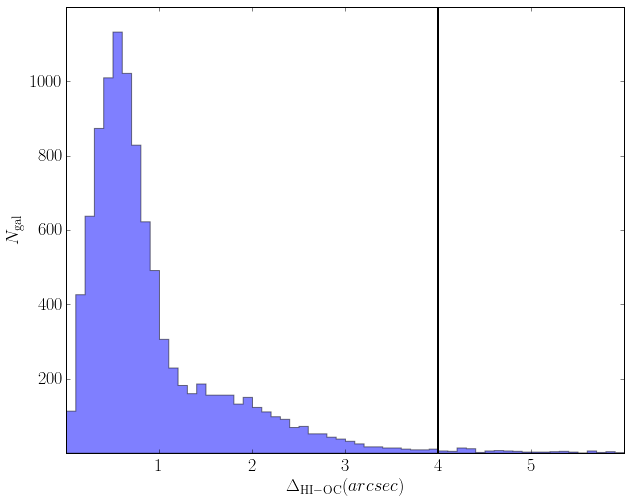

In [11]:
gz_radec = ICRS(galaxies['ra_1'],galaxies['dec_1'],unit=(u.degree,u.degree))
a70_radec = ICRS(alfalfa['OCra'],alfalfa['OCdec'],unit=(u.degree,u.degree))
i1,d1,_ = match_coordinates_sky(a70_radec,gz_radec)
# Plot up the distances:
d1_arcsec = d1*3600
_ = plt.hist(d1_arcsec,bins=np.linspace(0,6,61),histtype='stepfilled',color='b',alpha=0.5)
_ = plt.vlines(4,0,1200,color='k',lw=2)
plt.xlabel('$\Delta_{\mathrm{HI-OC}} (arcsec)$')
plt.ylabel('$N_{\mathrm{gal}}$')

i0 = range(len(i1))
matching_array = np.array([alfalfa['OCra'],alfalfa['OCdec'],i0,i1,d1_arcsec]).T
matching_table = Table(matching_array,names=('ra','dec','i_alfa','i_gz','d'))
keep_matches = matching_table['d'] <= 4 # within 4"?
matched_table = matching_table[keep_matches]
print('Have {} matches of GZ galaxies w.r.t. ALFALFA'.format(len(matched_table)))

In [12]:
for c in matched_table.colnames:
    print(len(np.unique(matched_table[c])))

9739
9365
9873
9873
9873


---> have 9342 matches of GZ galaxies w.r.t. ALFALFA


/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


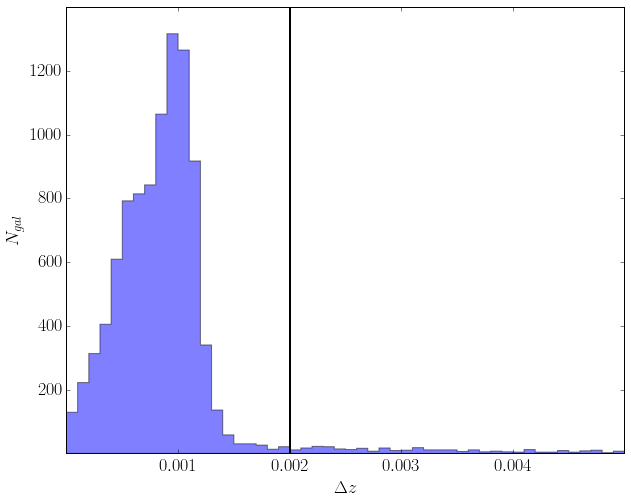

In [13]:
# Now check the redshifts match:

gas_matched = alfalfa[matched_table['i_alfa'].astype(int)]
gal_matched = galaxies[matched_table['i_gz'].astype(int)]

def z_from_D(D):
    return 70*D/3e5

z = z_from_D(gas_matched['dist'])
gas_matched['redshift'] =  z

_ = plt.hist(np.abs(gal_matched['REDSHIFT_1']-gas_matched['redshift']),alpha=0.5,histtype='stepfilled'
             ,bins=np.linspace(0,0.005,51))
_ = plt.vlines(0.002,0,1400,'k',lw=2)
plt.xlabel('$\Delta z$')
plt.ylabel('$N_{gal}$')

keep_z = np.abs(gal_matched['REDSHIFT_1']-gas_matched['redshift']) <= 0.002
gal_matched = gal_matched[keep_z]
gas_matched = gas_matched[keep_z]

final_index_matched = Table(np.array([gal_matched['index'],gas_matched['index']]).T,names=('i_gz','i_alfa'))
print('---> have {} matches of GZ galaxies w.r.t. ALFALFA'.format(len(gas_matched)))

In [14]:
spirals = (gal_matched['t01_smooth_or_features_a02_features_or_disk_debiased_rh']*
           gal_matched['t02_edgeon_a05_no_debiased_rh']*
           gal_matched['t04_spiral_a08_spiral_debiased_rh'] > 0.5) 

spirals_gal = gal_matched[spirals]
spirals_gas = gas_matched[spirals]
print('---> {}/{} matches are spiral galaxies'.format(len(spirals_gal),len(gal_matched)))

---> 4142/9342 matches are spiral galaxies


/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


Now save the table of matches:

In [19]:
index_matches[:,1][final_index_matched['i_gz'].astype(int)] = final_index_matched['i_alfa'].astype(int)
total_matches = Table(index_matches,names=('i_gz','i_alfa'))
total_matches.write('sdss_alfa70_matches.fits',overwrite=True)